# What are Level Set Trees?

### To-Dos
- Show in a table how the tree node statistics are recorded.
- Add text to the plots showing the density and mass levels and current point to consider.
- Overall review of the text.
- Do the section about repsenting the LST with the dendrogram.

*DeBaCl* is a Python package for building and using **Level Set Trees (LSTs)**. As the DeBaCl readme says, these trees are most often used for high-quality clustering, exploratory data analysis, understanding data topology, and detecting anomalies. Which is great, but **what exactly *is* an LST**?

In this notebook I'll work through each of the steps for constructing an LST. The code here is meant for illustrating the LST method; for actual usage, *DeBaCl* does all of the work for you.

## Starting with data

As usual, we start with data: 200 observations generated by the [Scikit-learn two moons function](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). Although the clusters in this dataset are obvious to the naked eye, it is a relatively complicated distribution---one that cannot be well-recovered by parametric clustering methods like K-means.

In [1]:
import debacl as dcl
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline

n = 200

moons, y = make_moons(n_samples=n, noise=0.1, random_state=19)

/home/brian/miniconda/envs/dcl-dev/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


One reason I'm using the two-moons dataset is that the feature space is 2-dimensional, so we can directly visualize what happens in feature space as we build the LST.

To minimize distracting plot code later, I'll define a couple utility functions along the way; these can be safely ignored.

/home/brian/miniconda/envs/dcl-dev/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


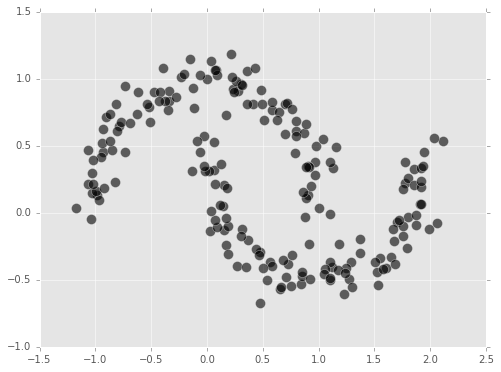

In [2]:
def plot_points(X, colorbar=False, **kwargs):
    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(figsize=(8, 6))
        cax = ax.scatter(X[:, 0], X[:, 1], s=100, cmap=plt.cm.hot_r, **kwargs)
        ax.set_xlim(-1.5, 2.5)
        ax.set_ylim(-1., 1.5)                             
        
        if colorbar:
            fig.set_size_inches((10, 6))
            cbar = fig.colorbar(cax)
            cbar.set_label('Density')
        
    return fig

fig = plot_points(moons, c='black', alpha=0.6)
fig.show()

## DeBaCl's output

Before I work through each of the individual steps in building the Level Set Tree, let's see what the finished product will look like. Below is the DeBaCl output for our synthetic two moons dataset, first in table form, then in dedrogram form. You can see there are 13 clusters in our LST, although the leaf nodes have only a couple of points each and would probably be pruned in a more realistic application.

Both the table and the dendrogram show the statistics for each cluster: `start_level`, `end_level`, `start_mass`, `end_mass`, and `size`. These statisics will be explained later as they are computed in the LST construction process.

In [3]:
k = 25  # number of neighbors for estimating connectivity and density

tree = dcl.construct_tree(moons, k=k)
tree

+----+-------------+-----------+------------+----------+------+--------+----------+
| id | start_level | end_level | start_mass | end_mass | size | parent | children |
+----+-------------+-----------+------------+----------+------+--------+----------+
| 0  |    0.000    |   0.194   |   0.000    |  0.300   | 200  |  None  |  [1, 2]  |
| 1  |    0.194    |   0.241   |   0.300    |  0.655   |  70  |   0    |  [3, 4]  |
| 2  |    0.194    |   0.273   |   0.300    |  0.885   |  70  |   0    |  [5, 6]  |
| 3  |    0.241    |   0.280   |   0.655    |  0.920   |  22  |   1    | [9, 10]  |
| 4  |    0.241    |   0.304   |   0.655    |  0.995   |  6   |   1    |    []    |
| 5  |    0.273    |   0.280   |   0.885    |  0.925   |  5   |   2    | [11, 12] |
| 6  |    0.273    |   0.277   |   0.885    |  0.900   |  5   |   2    |  [7, 8]  |
| 7  |    0.277    |   0.339   |   0.900    |  1.000   |  1   |   6    |    []    |
| 8  |    0.277    |   0.299   |   0.900    |  0.985   |  3   |   6    |    

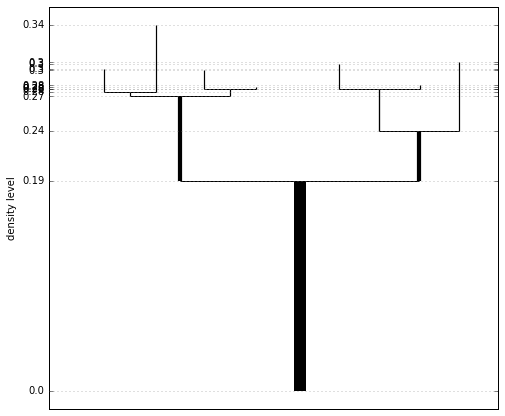

In [4]:
fig = tree.plot(form='density')[0]
fig.set_size_inches(8, 6)
fig.show()

## Building a level set tree

### 1. Construct a similarity graph

The similarity graph repesents each data point as a vertex, and connects any pair of vertices with an edge if those two points are neighbors. The definition of "neighbors" depends on a distance function and a policy for deciding when two points are sufficiently close. By default, DeBaCl uses Euclidean distance with a [k-nearest neighbors graph](https://en.wikipedia.org/wiki/Nearest_neighbor_graph), where each point is connected to the `k` points closest to it.

In [5]:
import networkx as nx

adjacency_list, radii = dcl.utils.knn_graph(moons, k=k)

similarity_graph = nx.from_dict_of_lists(
    {i: neighbors for i, neighbors in enumerate(adjacency_list)})

To show the similarity graph, let's plot the graph's edges underneath the data. Right away we can see that the graph is relatively dense, and connects all of the data into a single connected component.

Again, please ignore the definition of the `plot_edges` utility.

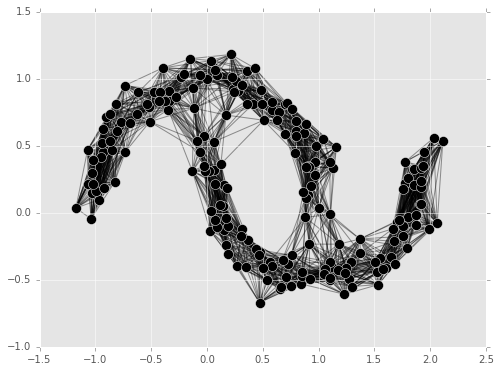

In [6]:
def plot_edges(X, graph, fig):
    ax = fig.gca()
    for v1, v2 in graph.edges():
        ax.plot((X[v1, 0], X[v2, 0]), (X[v1, 1], X[v2, 1]),
                color='black', alpha=0.4, zorder=0)
    return fig

fig = plot_points(moons, c='black')
fig = plot_edges(moons, similarity_graph, fig)
fig.show()

## 2. Estimate the probability density at each point

A probability density function describes how likely it is to draw an observation from any given location in our feature space. To build an LST we estimate the density function, but only at our observed data points.

By default, DeBaCl uses the k-nearest neighbors density estimate because it requires very little additional computation once we've computed a k-nearest neighbors similarity graph. [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) is another popular method that can be used instead.

The plot in the next cell shows points in denser regions of the space in darker colors, and vice versa. Intuitively, these points have `k` neighbors who are all very close to them, while points in less dense regions are further away from their `k`'th closest neighbor.

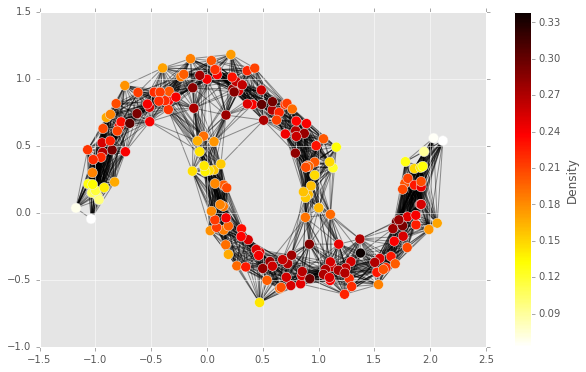

In [7]:
density = dcl.utils.knn_density(radii, n, p=2, k=k)
min_density = min(density)
max_density = max(density)

fig = plot_points(moons, c=density, colorbar=True, vmin=min_density, vmax=max_density)
fig = plot_edges(moons, similarity_graph, fig)
fig.show()

We also need to determine the order of the points from lowest to higher density (no need to sort the data points themselves though).

In [8]:
import numpy as np

filter_order = np.argsort(density)

## 3. Find the connected components in the full graph.

At its core, the LST method simply keeps track of the connected components in our similarity graph. In steps 4 and 5, we will change the similarity graph by removing vertices and edges, but to start we compute the connected components of the original similarity graph.

As the plots in cells 6 and 7 clearly show, there is only a single connected component. This is the usual case, but it's not required; a Level Set Tree can have several disconnected "root" components. Let's call our single root component "LST node 0". Because we haven't removed any points yet, we say node 0 has a "starting density level" a.k.a. "start level" of 0.0.

In [9]:
cc0 = list(nx.connected_component_subgraphs(similarity_graph))
print len(cc0)

1


## 4. Remove the lowest density point and re-compute connected components.

The core of the LST method is to compute connected components in the similarity graph as we remove points from smallest to largest density. Let's say we are about to remove data point $x$ from the similarity graph. Whatever our similarity graph looks like at this stage, $x$ must belong to a single connected component in the graph, call it $C$. When $x$ and its incident eges are removed, one of three things has to happen:

1. Connected component $C$ remains the same, except that $x$ is gone. In this case, we do nothing (like sections 5 and 6 above), and move on to the next point to be removed.

2. Component $C$ splits into multiple descendent components. Here we record statistics about the "end" of component $C$ and the "start" of $C$'s child components. In particular we say the density level of point $x$ is the "end level" of component $C$ and the "start level" of each of $C$'s child components. The "end mass"/"start_mass" value is the fraction of the data that has been removed at this stage.

3. Component $C$ vanishes, if $x$ was the very last point in $C$. In this case we record the "end level" and "end mass" of component $C$, but there are no child components for which to record the start level and start mass.

Importantly, in cases 1 and 2, the connected components are always *subgraphs* of their parent components. This means that the components form a hierarchy as points are removed, hence name level set *tree*.

The first element of the `filter_order` list is the index of the point with the lowest density. We remove this point's vertex from the similarity graph and the 10 edges that touched this point.

In [10]:
similarity_graph.remove_nodes_from([filter_order[0]])

Next we compute the connected components in the new, reduced similarity graph. In this case, there is still a single connected component. When this happens, the LST method does nothing. We simply move on to step 7.

In [11]:
cc1 = list(nx.connected_component_subgraphs(similarity_graph))
print len(cc1)

1


## 5. Repeat step 4 until all points have been removed.

### The first split

In this example, we can remove the first 38 points and still maintain our single connected component.

In [12]:
first_split_point = 60

similarity_graph.remove_nodes_from(filter_order[:first_split_point - 1])

cc2 = list(nx.connected_component_subgraphs(similarity_graph))
print "number of components:", len(cc2)

number of components: 1


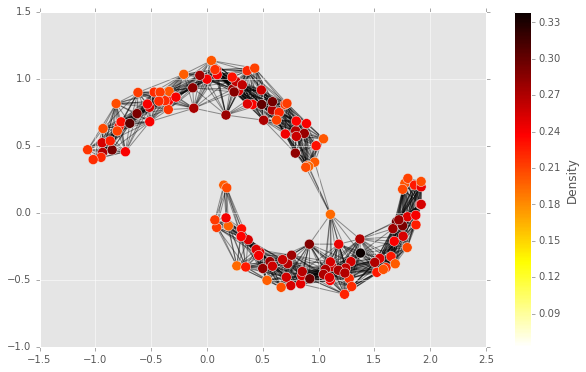

In [13]:
fig = plot_points(moons[similarity_graph], c=density[similarity_graph],
                  colorbar=True, vmin=min_density, vmax=max_density)
fig = plot_edges(moons, similarity_graph, fig)
fig.show()

In [14]:
similarity_graph.remove_nodes_from(filter_order[:first_split_point])
cc3 = list(nx.connected_component_subgraphs(similarity_graph))
cc3

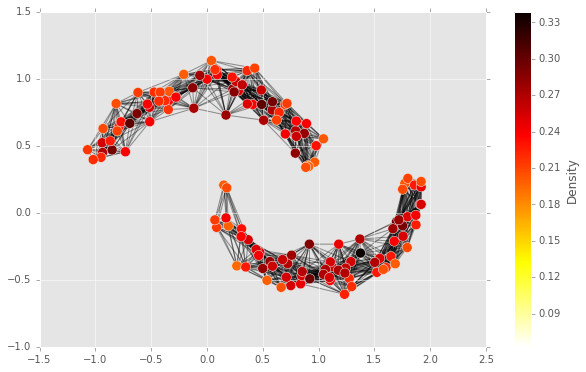

In [15]:
fig = plot_points(moons[similarity_graph], c=density[similarity_graph],
                  colorbar=True, vmin=min_density, vmax=max_density)
fig = plot_edges(moons, similarity_graph, fig)
fig.show()

- Keep track of the density level where the connected component started
- Keep track of the density level where the CC splits or vanishes
- Keep track of the *mass* levels at each of these points.

### A component vanishes

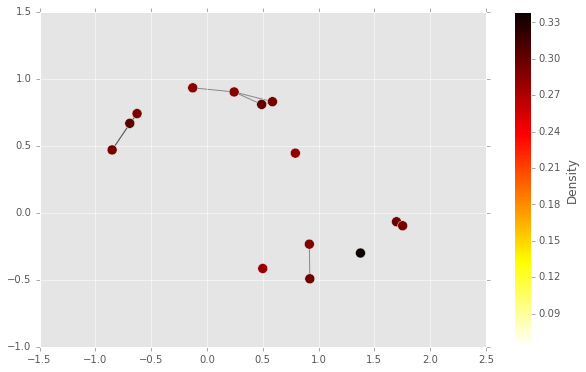

In [16]:
first_split_point = 187
similarity_graph.remove_nodes_from(filter_order[:first_split_point - 1])

fig = plot_points(moons[similarity_graph], c=density[similarity_graph],
                  colorbar=True, vmin=min_density, vmax=max_density)
fig = plot_edges(moons, similarity_graph, fig)
fig.show()

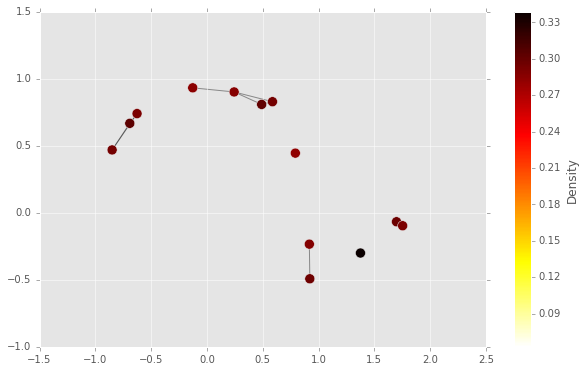

In [17]:
similarity_graph.remove_nodes_from(filter_order[:first_split_point])

fig = plot_points(moons[similarity_graph], c=density[similarity_graph],
                  colorbar=True, vmin=min_density, vmax=max_density)
fig = plot_edges(moons, similarity_graph, fig)
fig.show()

## 6. Draw the LST as a dendrogram

## Resources

- PyData talk (Dato GDrive)
    - Figures and code from the talk are on **lenana:~/projects/pydata_talk**
- JSS paper submission
- Dissertation

## Why are we doing all this? The statistical perspective.

As a statistical method, the LST approach assumes a dataset is drawn from an unobservable probability distribution. What we would *like* to be able to do is describe the shape of the probability distribution that generated our data. This is impossible for a couple reasons, but let's work through what we *would* do if we could.

- Show contours of the true PDF (get by sampling a lot of points from `make_moons`.
- Take two upper level sets. For each one, show the region, show the topologically connected components, and observe that they would form a tree.
- Intersect the connected components with the data to get data clusters.